In [1]:
# Data management
import pandas as pd
import pickle

# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, load_iris, make_moons, make_classification


# Math and Stat modules
import numpy as np
from scipy.stats import sem, randint
from random import choice

# Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve, cross_validate
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# Hyperparameter Optimization
#from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import loguniform


# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import seaborn as sns
from sklearn.tree import export_graphviz
%matplotlib inline

In [2]:
# carico i dati già preparati
X = pickle.load(open('data/feature_matrix.pickle','rb'))
y  = pickle.load(open('data/employee_label.pickle','rb'))
columns_name  = pickle.load(open('data/columns_name.pickle','rb'))

In [3]:
# train test split con dimensione test 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 225)

In [4]:
#definisco funzione per valutare le performance
def scores_val(y_train, y_train_pred):
    accuracy = accuracy_score(y_train, y_train_pred)
    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)
    
    dict= {"accuracy": accuracy, 
    "precision": precision,
    "recall" : recall,
    "f1" : f1}
    
    return dict    

# 1. Decision tree

In [5]:
# implemento un albero con massima profondità 4 per poterlo visualizzare
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=225)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=225)

In [6]:
target_name=np.array(['NotLeave', 'Leave'])
export_graphviz(
        tree_clf,
        out_file="employee_tree.dot",
        feature_names= columns_name,
        class_names= target_name,
        rounded=True,
        filled=True
    )

![](data/employee_tree.png)
- dal white box si può notare che già alla divisione iniziale si raggiunge quasi un nodo foglia andando a destra
- i nodi con indice di gini basso sono più vicini ad un nodo foglia
- ci sono 3 nodi con indice di gini troppo alto
- gini varia tra 0 e 0.5 in caso di classificazione binaria
- si può notare che come ci si aspettava il $JoiningYear = 2018$ viene utilizzato come prima variabile per fare splitting nel decision tree 

In [105]:
# implemento decision tree cambiando il numero di foglie minime all'interno del nodo
min_leaf = [5, 10, 20, 50, 100]

train_sizes, train_means, test_means, test_stds, train_stds = [],[],[],[],[]
for mlf in min_leaf:
    dt_mlf = DecisionTreeClassifier(min_samples_leaf=mlf, random_state=225, max_depth=15)
    train_size, train_scores, test_scores = learning_curve(dt_mlf,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10,
                                                       n_jobs=-1)
    print('fatto {}'.format(mlf))
    train_means.append(np.mean(train_scores, axis=1))
    train_stds.append(np.std(train_scores, axis=1))
    test_means.append(np.mean(test_scores, axis=1))
    test_stds.append(np.std(test_scores, axis=1))
    train_sizes.append(train_size)

fatto 5
fatto 10
fatto 20
fatto 50
fatto 100


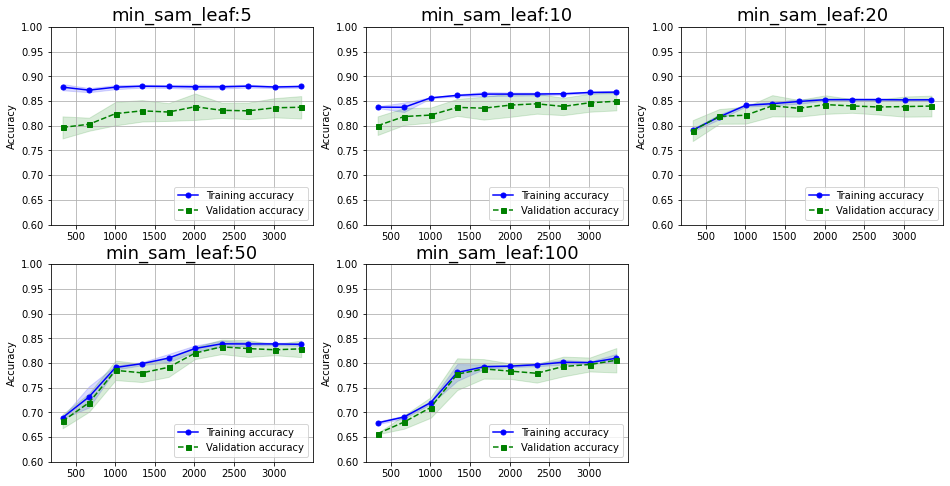

In [106]:
fig= plt.figure(figsize=(16, 8))
for i in range(5):
    ax = fig.add_subplot(231+i)
    ax.plot(train_sizes[i], train_means[i],
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes[i],
                 train_means[i] + train_stds[i],
                 train_means[i] - train_stds[i],
                 alpha=0.15, color='blue')
    ax.plot(train_sizes[i], test_means[i],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_sizes[i],
                 test_means[i] + test_stds[i],
                 test_means[i] - test_stds[i],
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.6,1))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(r"min_sam_leaf:{}".format(min_leaf[i]), fontsize=18)

- aumentando il numero minimo di foglie nei nodi le performance peggiorano
- l'overfitting diminuisce con l'aumentare del numero minimo di foglie
- la varianza è leggermente più elevata rispetto a SVM ma comunque non troppo alta
- il modello con min_sam_leaf = 20 sembra avere le migliori perfomance con un overfitting comunque accettabile 

In [39]:
# valutiamo tutte le performance del modello che sembra migliore
dt_clf = DecisionTreeClassifier(min_samples_leaf= 20, random_state=225, max_depth=15)
y_train_pred= cross_val_predict(dt_clf, X_train, y_train, cv=5)
scores_val(y_train, y_train_pred)

{'accuracy': 0.8409457281031704,
 'precision': 0.8354554358472086,
 'recall': 0.6679718089271731,
 'f1': 0.742384682332463}

- le performance sembrano buone rispetto ad altri algoritmi
- migliori f1 e accuracy rispetto al miglior modello di SVM e si ha anche un overfitting minore

## 1.1 Bagging classifier su decision tree
- utilizziamo decision tree addestrandolo su diversi partizionamenti del training set

In [27]:
# il bagging viene fatto con bootstrap
bag_clf = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf= 20, random_state=225,max_depth=15), n_estimators=500, max_samples=1000, bootstrap=True, n_jobs=-1)

In [28]:
# confronto del decision tree normale e con l'utilizzo di bagging
train_sizes, train_means, test_means, test_stds, train_stds = [],[],[],[],[]
for clf in [bag_clf, dt_clf]:
    train_size, train_scores, test_scores = learning_curve(clf,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
                                                       n_jobs=-1)
    print('fatto {}'.format(clf))
    train_means.append(np.mean(train_scores, axis=1))
    train_stds.append(np.std(train_scores, axis=1))
    test_means.append(np.mean(test_scores, axis=1))
    test_stds.append(np.std(test_scores, axis=1))
    train_sizes.append(train_size)

fatto BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15,
                                                        min_samples_leaf=20,
                                                        random_state=225),
                  max_samples=1000, n_estimators=500, n_jobs=-1)
fatto DecisionTreeClassifier(max_depth=15, min_samples_leaf=20, random_state=225)


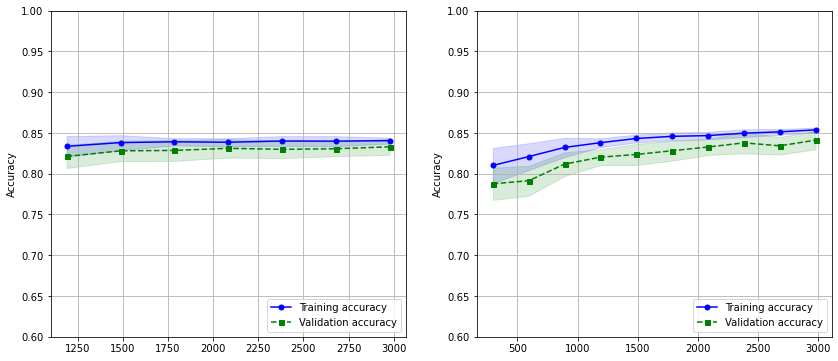

In [30]:
fig= plt.figure(figsize=(14, 6))
for i in range(2):
    ax = fig.add_subplot(121+i)
    ax.plot(train_sizes[i], train_means[i],
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes[i],
                 train_means[i] + train_stds[i],
                 train_means[i] - train_stds[i],
                 alpha=0.15, color='blue')
    ax.plot(train_sizes[i], test_means[i],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_sizes[i],
                 test_means[i] + test_stds[i],
                 test_means[i] - test_stds[i],
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.6,1))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')

- bagging performance leggermente inferiore in accuracy, ma anche overfitting inferiore
- sembra esserci anche una varianza inferiore

# 2. Random forest

In [107]:
# implemento random forest cambiando il numeromassimo di nodi foglia all'interno dell'albero
# utilizzo max_features= 4 -> sqrt(n_features)
max_leaf = [16, 32, 64, 128, 256]

train_sizes, train_means, test_means, test_stds, train_stds = [],[],[],[],[]
for mlf in max_leaf:
    rnf = RandomForestClassifier(n_estimators=250, max_leaf_nodes=mlf, max_features=4, random_state= 225)
    train_size, train_scores, test_scores = learning_curve(rnf,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10,
                                                       n_jobs=-1)
    print('fatto {}'.format(mlf))
    train_means.append(np.mean(train_scores, axis=1))
    train_stds.append(np.std(train_scores, axis=1))
    test_means.append(np.mean(test_scores, axis=1))
    test_stds.append(np.std(test_scores, axis=1))
    train_sizes.append(train_size)

fatto 16
fatto 32
fatto 64
fatto 128
fatto 256


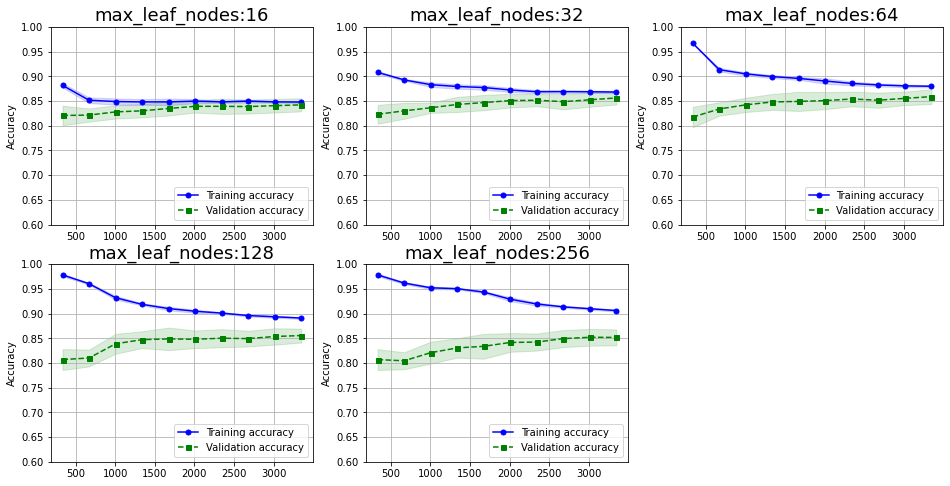

In [108]:
fig= plt.figure(figsize=(16, 8))
for i in range(5):
    ax = fig.add_subplot(231+i)
    ax.plot(train_sizes[i], train_means[i],
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes[i],
                 train_means[i] + train_stds[i],
                 train_means[i] - train_stds[i],
                 alpha=0.15, color='blue')
    ax.plot(train_sizes[i], test_means[i],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_sizes[i],
                 test_means[i] + test_stds[i],
                 test_means[i] - test_stds[i],
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.6,1))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(r"max_leaf_nodes:{}".format(max_leaf[i]), fontsize=18)

- aumentando il numero di nodi foglio si rischia di incorrere in overfitting
- aumenta anche la varianza con l'aumento dei nodi foglia
- il modello migliore si ha con max_leaf_nodes= 32

In [95]:
# valutiamo tutte le performance del modello che sembra migliore
rnf_clf = RandomForestClassifier(n_estimators=250, max_leaf_nodes=32, max_features=4, random_state=225)
rnf_pred = cross_val_predict(rnf_clf, X_train, y_train, cv=5)
scores_val(y_train, rnf_pred)

{'accuracy': 0.853036002149382,
 'precision': 0.9176201372997712,
 'recall': 0.6280344557556774,
 'f1': 0.7456996745699676}

- performance di random forest sono molto buone in precision, in recall performance inferiori rispetto a decision tree

In [60]:
# importanza delle feature
rnf_clf.fit(X_train,y_train)
named_feat_importance = dict(zip(columns_name, rnf_clf.feature_importances_))
sorted(named_feat_importance.items(), key=lambda x:x[1], reverse=True)

[('JoiningYear', 0.39575418400632745),
 ('PaymentTier', 0.14240635084220882),
 ('Gender', 0.12060605295189694),
 ('Education', 0.11886877512801103),
 ('City_cat3', 0.10586895054394753),
 ('Age', 0.033229330490872955),
 ('City_cat2', 0.0262560603848378),
 ('City_cat1', 0.025821165032270322),
 ('ExperienceInCurrentDomain', 0.02279639259737096),
 ('EverBenched', 0.008392738022256251)]

- si può notare l'importanza della feature $JoiningYear$ e successivamente delle altre features

# 2.1 Balanced random forest

In [100]:
# valutiamo le performance di extra trees con gli stessi paremetri per il modello migliore di random forest
# si utilizza bootstrap con classi bilanciate
brnf_clf = BalancedRandomForestClassifier(n_estimators=250, max_leaf_nodes=32, max_features=4, random_state=225)
brnf_pred = cross_val_predict(brnf_clf, X_train, y_train, cv=5)
scores_val(y_train, brnf_pred)

{'accuracy': 0.8401397098334229,
 'precision': 0.7894736842105263,
 'recall': 0.7282693813625685,
 'f1': 0.7576374745417516}

- le performance sembrano di inferiori rispetto al semplice random forest in accuracy e precision, ma migliori in recall
- recall molto alta 
- risultato atteso

# 3. Extra trees

In [57]:
# valutiamo le performance di extra trees con gli stessi paremetri per il modello migliore di random forest
et_clf = ExtraTreesClassifier(n_estimators=250, max_leaf_nodes=32, max_features=4, random_state=225)
et_pred = cross_val_predict(et_clf, X_train, y_train, cv=5)
scores_val(y_train, et_pred)

{'accuracy': 0.830198817839871,
 'precision': 0.9066834804539723,
 'recall': 0.5630383711824589,
 'f1': 0.6946859903381642}

- le performance sono buone, tuttavia sono sempre inferiori a random forest 

# 4. Ada boost classifier

In [112]:
# valutiamo le performance di adaboost classifier
ada_clf= AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=100, algorithm='SAMME.R', learning_rate=0.2)
ada_pred = cross_val_predict(ada_clf, X_train, y_train, cv=5)
scores_val(y_train, ada_pred)

{'accuracy': 0.8148844707146695,
 'precision': 0.7717190388170055,
 'recall': 0.653876272513704,
 'f1': 0.7079270877490461}

- performance buone in generale, ma inferiori a decision tree
- in recall meglio di random forest e di extra trees

# 5. KNN

In [88]:
# implemento random forest cambiando il numeromassimo di nodi foglia all'interno dell'albero
# utilizzo max_features= 4 -> sqrt(n_features)
neigh = [ 2, 5, 7, 10, 15]

train_sizes, train_means, test_means, test_stds, train_stds = [],[],[],[],[]
for n in neigh:
    knn = KNeighborsClassifier(n_neighbors = n)
    train_size, train_scores, test_scores = learning_curve(knn,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10,
                                                       n_jobs=-1)
    print('fatto {}'.format(n))
    train_means.append(np.mean(train_scores, axis=1))
    train_stds.append(np.std(train_scores, axis=1))
    test_means.append(np.mean(test_scores, axis=1))
    test_stds.append(np.std(test_scores, axis=1))
    train_sizes.append(train_size)

fatto 2
fatto 5
fatto 7
fatto 10
fatto 15


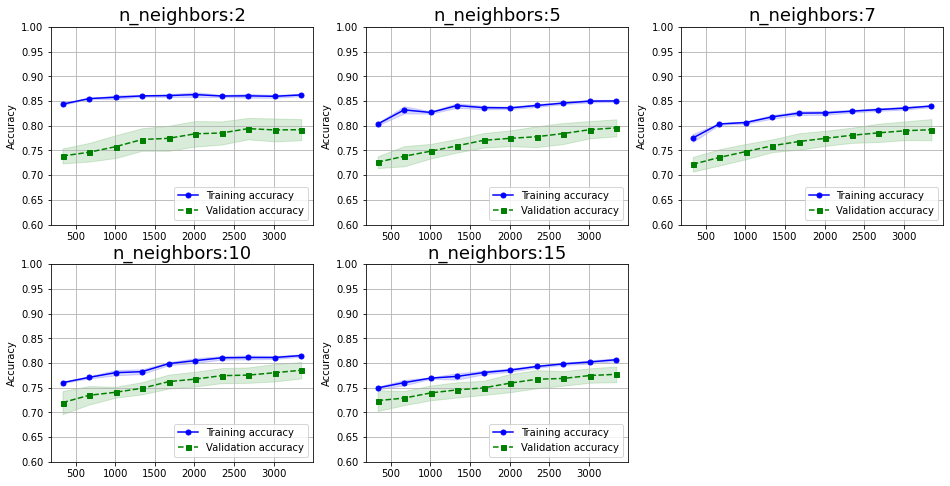

In [90]:
fig= plt.figure(figsize=(16, 8))
for i in range(5):
    ax = fig.add_subplot(231+i)
    ax.plot(train_sizes[i], train_means[i],
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes[i],
                 train_means[i] + train_stds[i],
                 train_means[i] - train_stds[i],
                 alpha=0.15, color='blue')
    ax.plot(train_sizes[i], test_means[i],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_sizes[i],
                 test_means[i] + test_stds[i],
                 test_means[i] - test_stds[i],
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.6,1))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(r"n_neighbors: {}".format(neigh[i]), fontsize=18)

- con un numero di vicini troppo basso si incorre in overfitting
- nonostante il leggero overfitting, il modello che ha comunque un buon valore di accuracy è n_neighbors= 10, dopo le performance si abbassano ulteriormente senza diminuire overfitting

In [92]:
# valutiamo tutte le performance del modello che sembra migliore
knn = KNeighborsClassifier(n_neighbors = 10)
knn_pred = cross_val_predict(ada_clf, X_train, y_train, cv=5)
scores_val(y_train, knn_pred)

{'accuracy': 0.8164965072541644,
 'precision': 0.7724770642201835,
 'recall': 0.6593578700078309,
 'f1': 0.7114490916772286}

- risultati buoni in recall, meno in precision